In [2]:
import pandas as pd

import collections

import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def plot_neighbourhood(node, G, candidates, labels=False):
    # plot the neighbourhood of the top node ENSG00000101773
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]

    sub_G = nx.Graph(sub_G) # unfreeze the graph
    sub_G.remove_edges_from(nx.selfloop_edges(sub_G)) # removing self-loops

    color_map = ['orangered' if node in candidates_in_neighbourhood else 'lightblue' for node in sub_G]
    pos=nx.spring_layout(sub_G)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.set_title(f"Neighbourhood of {node}")
    nx.draw_networkx(sub_G, pos=pos, with_labels=False, node_size=100, alpha=0.9, ax=ax, node_color=color_map)

    if labels:
        # plot candidates labels
        labels = {}
        for node in sub_G.nodes():
            if node in candidates_in_neighbourhood:
                labels[node] = node

        pos_higher = {}
        for k, v in pos.items():
            if(v[1]>0):
                pos_higher[k] = (v[0]-0.1, v[1]+0.1)
            else:
                pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        nx.draw_networkx_labels(sub_G, pos=pos_higher, labels=labels, font_size=10, font_color='tomato')
    
    _ = ax.axis('off')

In [4]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

### Analyze interactome

In [5]:
# number of proteins
len(G.nodes())

14465

In [6]:
# number of interactions
G.number_of_edges()

92064

Text(0, 0.5, 'number of nodes')

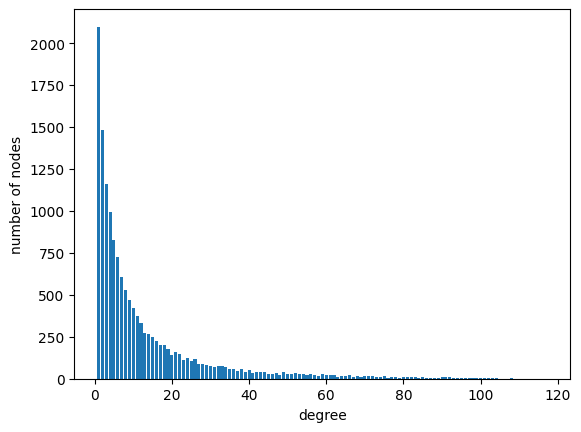

In [7]:
# degree histogram
degrees = sorted([d for n, d in G.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [8]:
# average degree
sum([d for _, d in G.degree()]) / G.number_of_nodes() # doesn't provide much information for a power-law distribution

12.7292084341514

### Count candidate genes for each node neighbourhood

In [9]:
# count candidate genes for each node
d = {}
d2 = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    isCandidate = True if node in candidates else False

    d[node] = candidates_in_neighbourhood_cnt
    d2[node] = [candidates_in_neighbourhood_cnt, isCandidate, G.degree(node)]

In [10]:
s = pd.Series(d, name='# candidates in neighbourhood')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000170365    5
ENSG00000130957    5
ENSG00000164053    5
ENSG00000165140    5
ENSG00000197299    4
                  ..
ENSG00000255112    0
ENSG00000164078    0
ENSG00000081803    0
ENSG00000239305    0
ENSG00000137767    0
Name: # candidates in neighbourhood, Length: 14465, dtype: int64

In [11]:
s2 = pd.Series(d2, name='# candidates in neighbourhood')
s2.index.name = 'Gene'
s2.reset_index()
s2.sort_values(ascending=False)

Gene
ENSG00000170365    [5, False, 92]
ENSG00000164053    [5, False, 38]
ENSG00000165140    [5, False, 33]
ENSG00000130957    [5, False, 17]
ENSG00000138376     [4, True, 64]
                        ...      
ENSG00000142556     [0, False, 1]
ENSG00000198417     [0, False, 1]
ENSG00000132823     [0, False, 1]
ENSG00000130720     [0, False, 1]
ENSG00000102935     [0, False, 1]
Name: # candidates in neighbourhood, Length: 14465, dtype: object

> Information about **ENSG00000170365:**

Gene SMAD1

Protein Q15797 *Mothers against decapentaplegic homolog 1* (embryonic development, cell differentiation, and tissue homeostasis)

may be associated with susceptibility to pulmonary hypertension (plexiform lesions of proliferating endothelial cells in pulmonary arterioles)

> Information about **ENSG00000164053**:

Gene ATRIP

Protein Q8WXE1 *ATR-interacting protein* (checkpoint signaling after DNA damage)

> Information about **ENSG00000165140:**

Gene FBP1

Protein P09467 *Fructose-1,6-bisphosphatase 1* (rate-limiting enzyme in gluconeogenesis)

> Information about **ENSG00000130957**:

Gene FBP2

Protein O00757 *Fructose-1,6-bisphosphatase isozyme 2*

Text(0, 0.5, 'number of nodes')

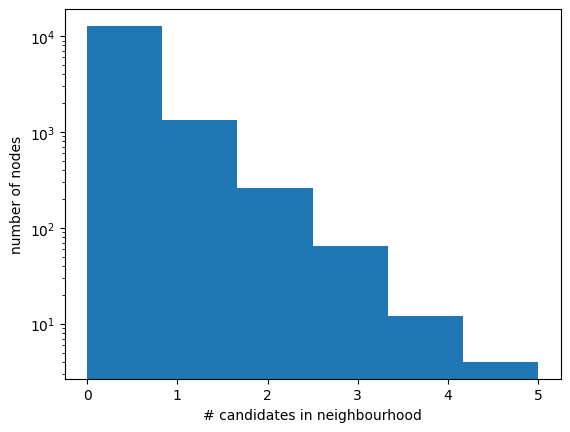

In [12]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
ax.set_xlabel("# candidates in neighbourhood")
ax.set_ylabel("number of nodes")

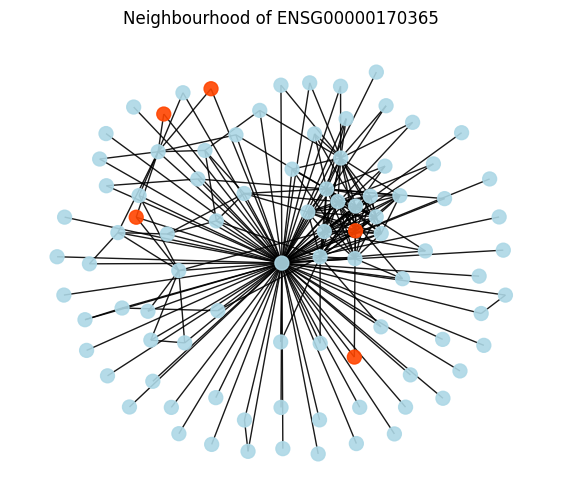

In [13]:
plot_neighbourhood("ENSG00000170365", G, candidates, labels=False)

In [14]:
# relation between the number of candidate genes vs degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = [candidates_in_neighbourhood_cnt, G.degree(node)]

df = pd.DataFrame.from_dict(d, orient='index', columns=['# candidates in neighbourhood', 'degree'])

<Axes: xlabel='degree', ylabel='# candidates in neighbourhood'>

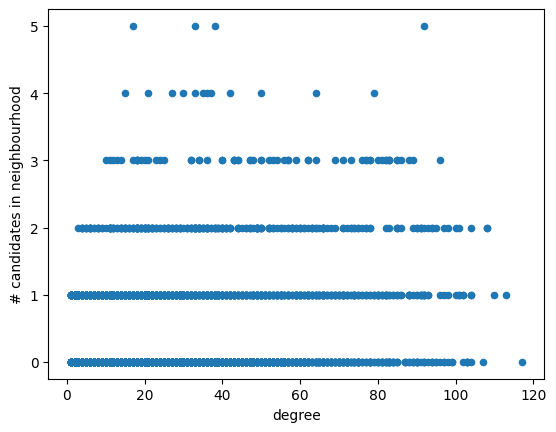

In [15]:
df.plot.scatter(x='degree', y='# candidates in neighbourhood')

In [16]:
# fraction of candidates that are present in interactome
len([candidate for candidate in candidates if candidate in G.nodes()]) / len(candidates)

# ~50% means that the second half of candidate genes has been filtered out during the building of interactome (e.g. because they form hubs >120 connections)

0.7894736842105263

In [17]:
# average degree of infertility candidate genes
d = {}

for node in G.nodes():
    if node in candidates:
        d[node] = G.degree(node)

sum([deg for n, deg in d.items()]) / len(d.keys())

16.6796875

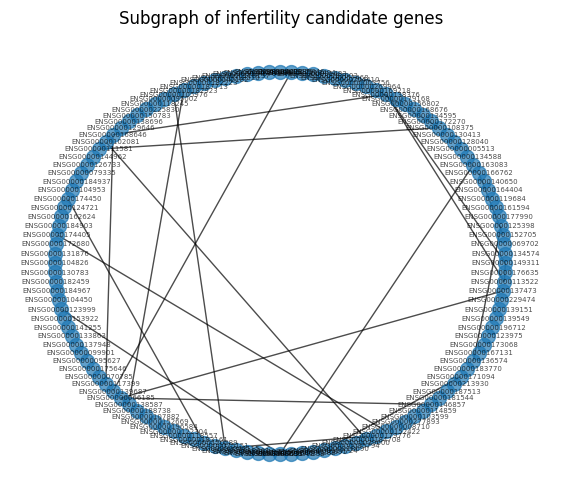

In [18]:
# subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])

candidates_sub_G = nx.Graph(candidates_sub_G) # unfreeze the graph
candidates_sub_G.remove_edges_from(nx.selfloop_edges(candidates_sub_G)) # removing self-loops

plt.figure(figsize=(7, 6))
ax = plt.gca()
ax.set_title(f"Subgraph of infertility candidate genes")
# nx.draw_networkx(candidates_sub_G, with_labels=False, node_size=100, alpha=0.9, ax=ax)
nx.draw_circular(candidates_sub_G, with_labels=True, node_size=100, alpha=0.7, ax=ax, font_size=5)
_ = ax.axis('off')

In [19]:
# number of nodes and edges in subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])
candidates_sub_G.number_of_nodes(), candidates_sub_G.number_of_edges()

(128, 46)

### Score 1: Count candidate genes for each node and divide by node degree

In [20]:
# count candidate genes for each node and divide by node degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = candidates_in_neighbourhood_cnt / G.degree(node)

In [21]:
s = pd.Series(d, name='Score 1')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000119636    1.0
ENSG00000185634    1.0
ENSG00000162402    1.0
ENSG00000183066    1.0
ENSG00000184261    1.0
                  ... 
ENSG00000255112    0.0
ENSG00000164078    0.0
ENSG00000081803    0.0
ENSG00000239305    0.0
ENSG00000137767    0.0
Name: Score 1, Length: 14465, dtype: float64

Text(0, 0.5, 'number of nodes')

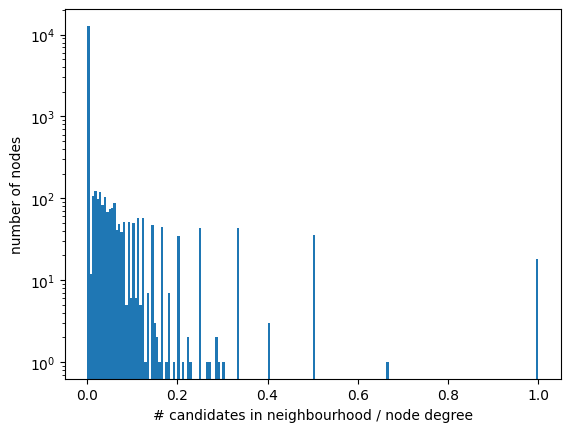

In [22]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
# ax = s[s>0].plot.hist(bins=len(set(s.values)))
ax.set_xlabel("# candidates in neighbourhood / node degree")
ax.set_ylabel("number of nodes")

In [23]:
# same as above, but get more node info

# count candidate genes for each node and divide by node degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)

    isCandidate = True if node in candidates else False

    # calculate score 1
    score = candidates_in_neighbourhood_cnt / G.degree(node)

    d[node] = [score, candidates_in_neighbourhood_cnt, G.degree(node), isCandidate]

In [24]:
df = pd.DataFrame.from_dict(d, orient='index', columns=['score 1', '# candidates in neighbourhood', 'degree', 'isCandidate'])
df[df['degree'] > 10].sort_values(by='score 1', ascending=False).head()

,score 1,# candidates in neighbourhood,degree,isCandidate
ENSG00000130957,0.294118,5,17,False
ENSG00000122641,0.272727,3,11,True
ENSG00000174371,0.266667,4,15,False
ENSG00000136943,0.250000,3,12,False
ENSG00000175643,0.230769,3,13,False


In [25]:
df[(df['score 1'] != 0) & (df['degree'] > 5)].sort_values(by='score 1', ascending=False).head()

,score 1,# candidates in neighbourhood,degree,isCandidate
ENSG00000133067,0.333333,2,6,False
ENSG00000181274,0.333333,2,6,False
ENSG00000139292,0.333333,2,6,False
ENSG00000140105,0.333333,2,6,False
ENSG00000174898,0.333333,2,6,False


### Convert networkx to igraph

In [37]:
g = ig.Graph.TupleList(G.edges(), directed=False)

### Plot interactome

In [45]:
def save_graph(G,file_name):
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    del fig

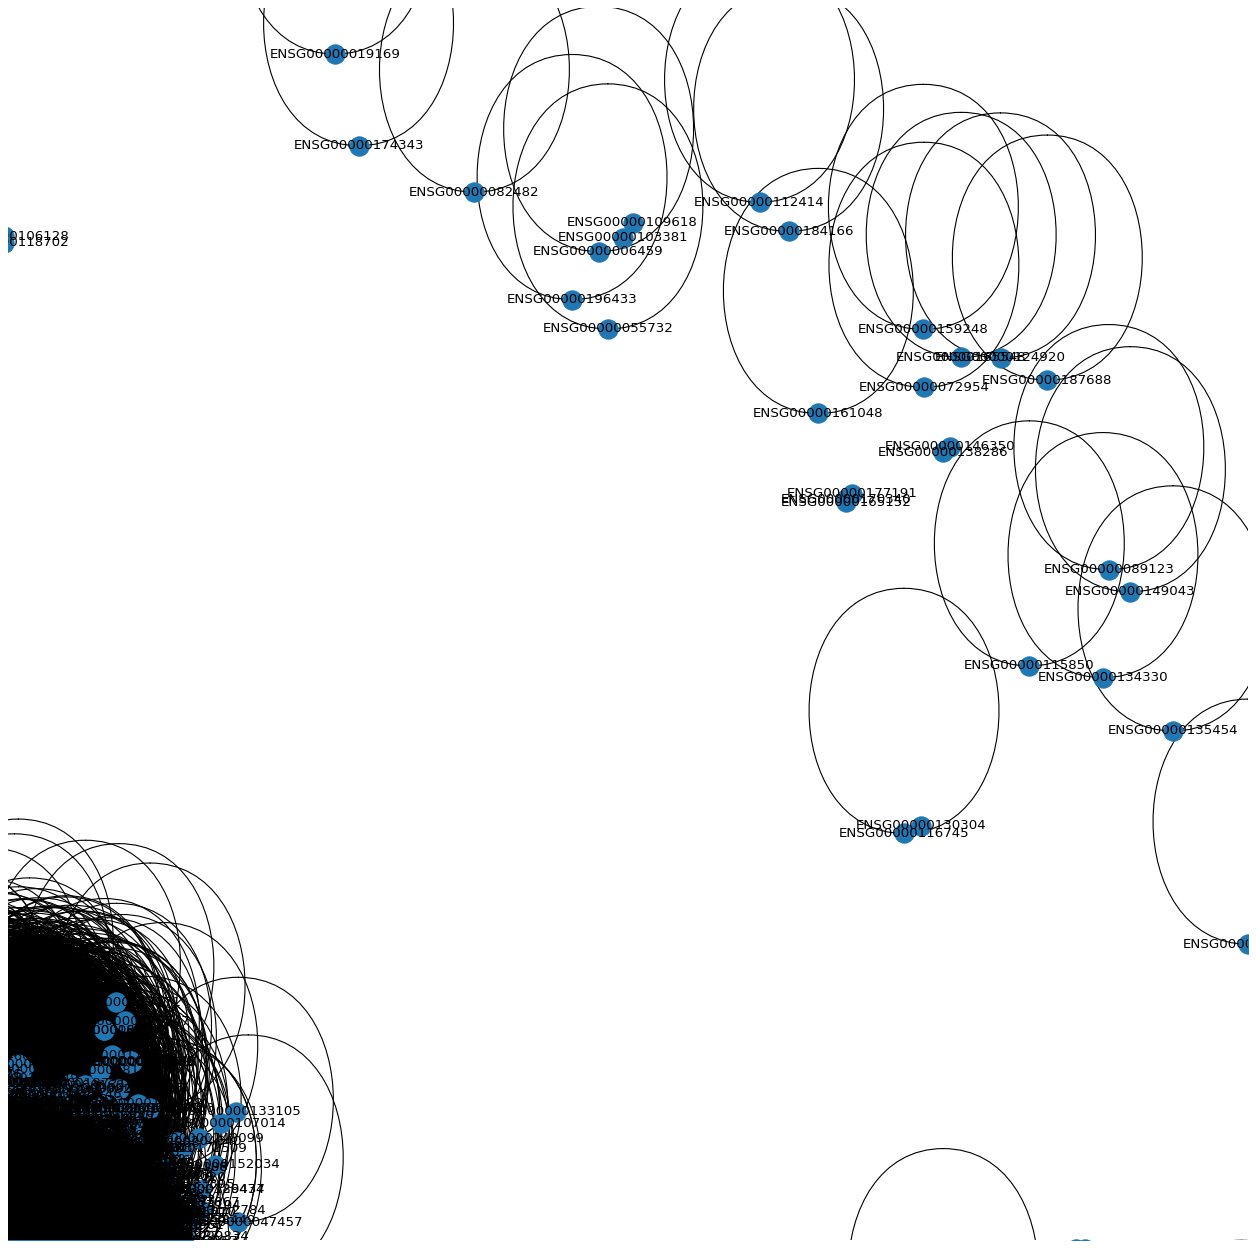

In [46]:
save_graph(G,"interactome.pdf") # it takes 8 min